In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [15]:
df_Tata = pd.read_csv("TATAMOTORS_with_indicators_.csv")

In [16]:
df_Tata['date'] = pd.DatetimeIndex(pd.date_range('2021-11-20 02:59:00+05:30', periods=len(df_Tata),  freq='min')) #sobreescribo mi columna date con nuevo range por minutos 
df_Tata = df_Tata.set_index('date') # pongo la columna fecha como indice. para facilitar el analisis.

df_Tata['year'] = df_Tata.index.year
df_Tata['month'] = df_Tata.index.month
df_Tata['day'] = df_Tata.index.day
df_Tata['weekday'] = df_Tata.index.day_name()
df_Tata['weekofyear'] = df_Tata.index.isocalendar().week
df_Tata['hour'] = df_Tata.index.hour
df_Tata['minute'] = df_Tata.index.minute

weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_Tata['weekday'] = df_Tata['weekday'].map(weekday_mapping)

# muestra de los datos por día
data_daily = df_Tata['close'].resample('D').mean()

#df_Tata = df_Tata.drop(columns=["high","low"])
#df_Tata = df_Tata.drop(columns=["sma20","sma10","sma15","ema5","ema10","ema15","middleband","lowerband","TRIMA5","TRIMA20","KAMA10","KAMA20","MOM10","MOM15","ROC10","ROC20","ATR","macd510","macd520","macd1020","macd1520","ADX5","ADX20"])


In [17]:
data_daily

date
2021-11-20 00:00:00+05:30    572.596511
2021-11-21 00:00:00+05:30    563.824410
2021-11-22 00:00:00+05:30    542.916493
2021-11-23 00:00:00+05:30    513.300764
2021-11-24 00:00:00+05:30    452.787257
                                ...    
2022-02-14 00:00:00+05:30    492.409965
2022-02-15 00:00:00+05:30    490.611701
2022-02-16 00:00:00+05:30    479.082951
2022-02-17 00:00:00+05:30    503.352951
2022-02-18 00:00:00+05:30    498.247300
Freq: D, Name: close, Length: 91, dtype: float64

In [18]:
# Auto ARIMA

size = int(len(data_daily)*0.8)
train = data_daily[:size]
test = data_daily[size:]
arima_model = auto_arima(train, 
                         start_p=1, 
                         d=0, 
                         start_q=0, 
                         max_p=5, 
                         max_d=5, 
                         max_q=5,
                         start_P=0, 
                         D=1, 
                         start_Q=0, 
                         max_P=5, 
                         max_D=5, 
                         max_Q=5,  
                         m=1,
                         seasonal=True, # que considere modelos estacionales.
                         error_action='warn', # que emita un warning si encuentra un error.
                         trace=True, # que imprima informacion mientras busca el modelo optimo
                         suppress_warnings=True,# que suprima las adverencias  durante el ajuste del modelo.
                         stepwise=True, # que un algoritmo buscara paso a paso el modelo optimo
                         random_state=20, 
                         n_fits=50 # ajustes a realizar durante la busqueda
                        )

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=703.260, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=925.504, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=842.875, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1052.542, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=697.710, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=698.938, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=697.878, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=696.183, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=697.989, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=791.317, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=699.757, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=696.383, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.653 seconds


In [19]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -344.092
Date:                Thu, 30 Nov 2023   AIC                            696.183
Time:                        05:29:58   BIC                            705.290
Sample:                    11-20-2021   HQIC                           699.809
                         - 01-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.8301     15.061      0.586      0.558     -20.689      38.349
ar.L1          0.9742      0.038     25.376      0.000       0.899       1.049
ma.L1          0.3980      0.129      3.089      0.002       0.145       0.651
sigma2       786.3162    128.033      6.141      0.000     535.375    1037.257
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.64   Prob(JB):                         0.82
Heteroskedasticity (H):               0.36   Skew:                             0.15
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

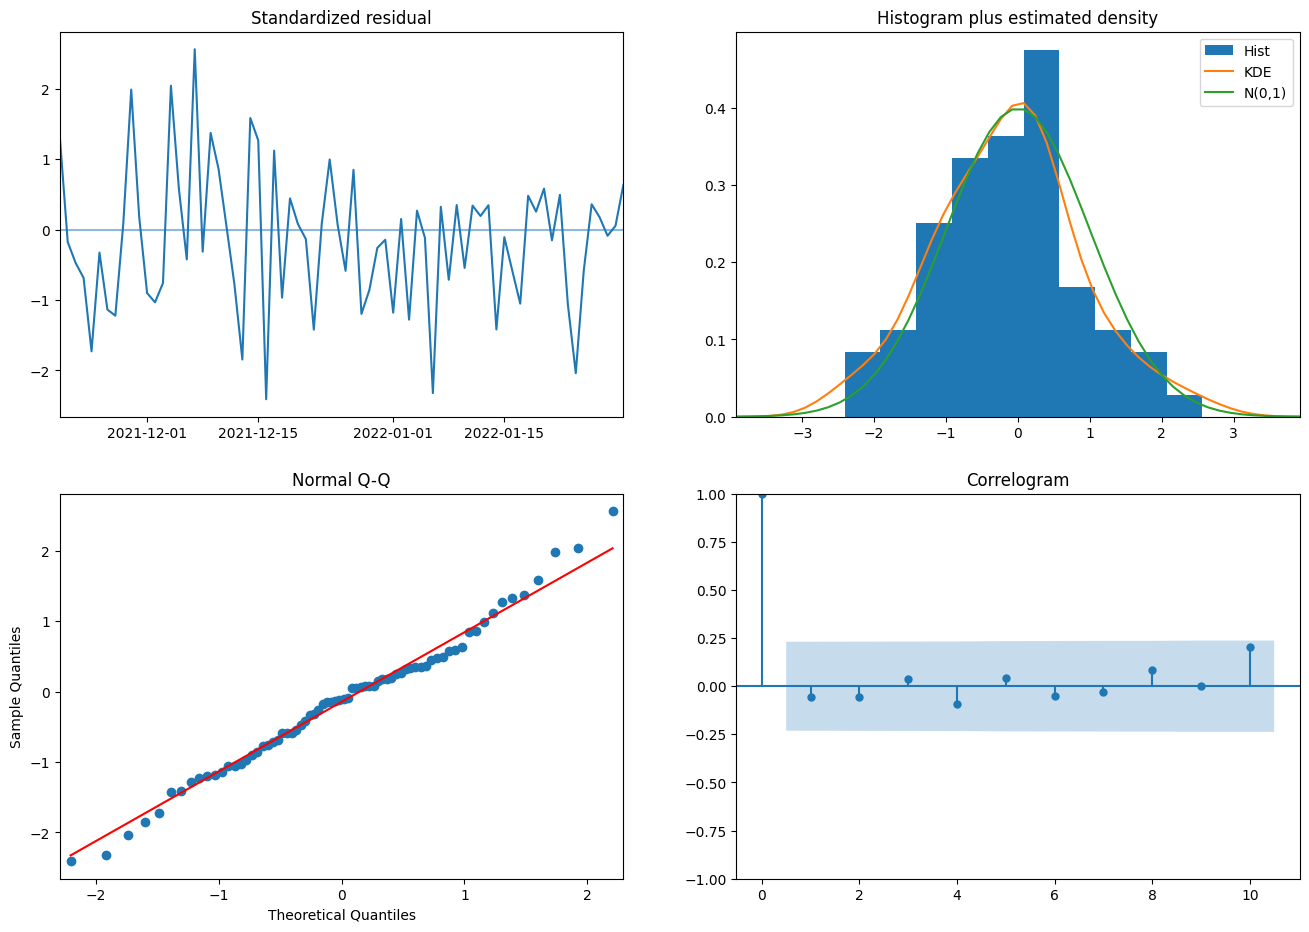

In [20]:
arima_model.plot_diagnostics(figsize=(16,11));

Actual values:  [139.111 133.292 161.119 179.281 236.972 317.717 319.517 302.164 308.987
 335.846]
Predictions:    [148.274 153.284 158.164 162.919 167.552 172.065 176.462 180.746 184.919
 188.984]
RMSE: 168.537
MAE: 139.303
MAPE: 0.371
MASE: 5.751
R^2 score: -0.991


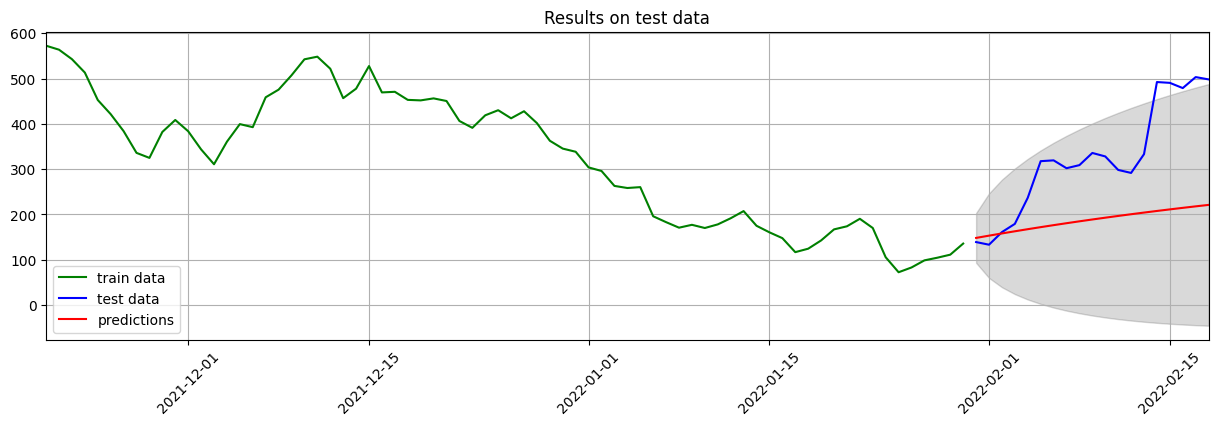

In [21]:
y_forec, conf_int  = arima_model.predict(len(test),return_conf_int=True,alpha=0.05)
pred = pd.Series(y_forec, index=test.index)
pred.columns = ['predicted']
confidence = pd.DataFrame(conf_int, columns=['lower', 'upper'])

plt.figure(figsize=(15,4))
plt.plot(train, c='green', label='train data')
plt.plot(test, c='blue', label='test data')
plt.plot(pred, c='red', label='predictions')
plt.legend()
plt.grid(), plt.margins(x=0)
plt.title('Results on test data'), plt.xticks(rotation=45)
plt.fill_between(test.index, confidence['lower'],
                 confidence['upper'], color='k', alpha=.15)


from sklearn.metrics import r2_score
print('Actual values: ', np.around(test[:10].tolist(),3))
print('Predictions:   ', np.around(pred[:10].tolist(),3))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, pred)))
MAE = mean_absolute_error(test, pred)
MAPE = np.mean(np.abs(pred - test)/np.abs(test))
MASE = np.mean(np.abs(test - pred ))/(np.abs(np.diff(train)).sum()/(len(train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(test, pred))



In [22]:
import pickle

# Guardar el modelo en un archivo pickle
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)